# 네이버 리뷰 데이터를 활용한 한국어 감정 분석
네이버 영화 리뷰데이터(Naver Sentiment Movie Corpus,NSMC)를 활용해서 감정분석을 수행

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 34.1 MB/s eta 0:00:00


In [ ]:
import os

import numpy as np
import pandas as pd

from datetime import datetime
import json
import re

from konlpy.tag import Okt

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tqdm.notebook import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 데이터 불러오기

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', header=0, delimiter='\t' ,quoting=3)
test = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', header=0, delimiter='\t' ,quoting=3)

In [ ]:
display(train.head())
display(test.head())

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
train.shape, test.shape

((150000, 3), (50000, 3))

## 데이터 탐색

In [2]:
train.info()

NameError: name 'train' is not defined

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
train['document'].nunique()

146182

In [ ]:
# 중복제거
train = train.drop_duplicates('document')
train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
# 결측치 제거
train[train.document.isnull()] #null, na, nan, None

,id,document,label
25857,2172111,NaN,1


In [ ]:
# 결측치를 제거하고 결과를 확인하세요.
train.dropna(inplace=True) # (inplace=True)해야 반영됨
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


### 리뷰는 긍정데이터와 부정데이터로 라벨링 되어 있습니다. 데이터의 분포를 확인하세요

In [ ]:
train['label'].value_counts()

,count
label,
0,73342
1,72840


## 전처리

In [ ]:
def preprocessing(review):
    # review : 전처리할 텍스트

    okt = Okt()

    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣\s]", "", review)

    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.pos(review_text, stem=True) # 통일화 적용

    # 3. 불용어 제거
    stop_words = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
    word_review = [(token, pos) for token, pos in word_review if not token in stop_words]

    # 4. 노이즈 제거 (글자 1개는 노이즈로 간주하자.)
    word_review = [(token, pos) for token, pos in word_review if len(token) > 1]

    # 5. 명사, 동사, 형용사 추출
    # word_review = [token for token, pos in word_review]
    word_review = [token for token, pos in word_review if pos in ['Noun', 'Verb', 'Adjective']]

    return word_review

## train, test 전처리 수행

In [ ]:
clean_review = []
clean_review_test = []

for review in tqdm(train['document']):
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_review.append(preprocessing(review))
    else:
        clean_review.append([])

for review in tqdm(test['document']):
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_review_test.append(preprocessing(review))
    else:
        clean_review_test.append([])

  0%|          | 0/146182 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
# # 전처리 데이터 저장하기
# import pickle

# with open('clean_review.pkl', 'wb') as f:
#     pickle.dump(clean_review, f)
# with open('clean_review_test.pkl', 'wb') as f:
#     pickle.dump(clean_review_test, f)

In [ ]:
# # 전처리 데이터 불러오기
# import pickle

# # clean_review 로 불러오기
# with open('/content/clean_review.pkl', 'rb') as f :
#     clean_review = pickle.load(f)

# # clean_review_test 로 불러오기
# with open('/content/clean_review_test.pkl', 'rb') as f :
#     clean_review_test = pickle.load(f)

텍스트를 정수로 바꾸는 것을 인코딩이라고 합니다.   
자주 사용되는 인코딩 방법은 단어를 빈도순으로 정렬하고, 많이 등장한 단어부터 차례대로 숫자를 부여하는 방법입니다.

케라스의 fit_on_texts() 함수를 사용하여, 단어 인덱스 딕셔너리를 생성하겠습니다.

In [ ]:
tokenizer = Tokenizer() # 토큰화 함수 지정

# 단어 인덱스 구축
tokenizer.fit_on_texts(clean_review)

In [ ]:
word_vocab = tokenizer.word_index # 딕셔너리 형태
print("전체 단어 개수: ", len(word_vocab)) # 전체 단어 개수 확인

In [ ]:
print(word_vocab)

In [ ]:
X_train = tokenizer.texts_to_sequences(clean_review) # 문자열 -> 인덱스 리스트

### 라벨링 데이터를 y_train 데이터로 분리합니다

In [ ]:
# 각 리뷰의 감정을 넘파이 배열로 만듭니다
y_train = np.array(train['label'])

In [ ]:
len(X_train), len(y_train)

In [ ]:
from torch.utils.data import DataLoader, Dataset
class MyDataset(Dataset):
    def __init__(self, data, TEXT_vocab):
        self.data = data
        self.TEXT_vocab = TEXT_vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        return torch.tensor(self.TEXT_vocab(text)), torch.tensor(label)

In [ ]:
train_dataset = MyDataset(train_data, TEXT_vocab)
valid_dataset = MyDataset(valid_data, TEXT_vocab)

In [ ]:
print(train_dataset[0])

(tensor([185,  87,  26,  20, 139,   4,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]), tensor(0))


In [ ]:
BATCH_SIZE = 256

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.W_q = nn.Linear(hidden_dim, hidden_dim)  # Query 변환
        self.W_k = nn.Linear(hidden_dim, hidden_dim)  # Key 변환
        self.W_v = nn.Linear(hidden_dim, hidden_dim)  # Value 변환
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)  # Concat 후 차원 축소

    def forward(self, query, lstm_outputs, mask=None):
        # query: (batch_size, hidden_dim) -> Query는 LSTM의 마지막 출력
        # lstm_outputs: (batch_size, seq_len, hidden_dim) -> Key와 Value는 LSTM의 모든 hidden states

        # Query, Key, Value 변환
        query = self.W_q(query).unsqueeze(1)  # (batch_size, 1, hidden_dim)
        keys = self.W_k(lstm_outputs)  # (batch_size, seq_len, hidden_dim)
        values = self.W_v(lstm_outputs)  # (batch_size, seq_len, hidden_dim)

        # Attention Score 계산
        # ( 1 x hd ) (hd x seq) --> (1 x seq)
        attn_scores = torch.bmm(query, keys.transpose(1, 2))  # (batch_size, 1, seq_len), 위치교환

        # Mask 적용: 패딩 부분에 큰 음수 값을 더하여 softmax 후 0에 가깝게 만듦
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask.unsqueeze(1) == 0, float('-inf'))  # mask: (batch_size, 1, seq_len)

        attn_weights = F.softmax(attn_scores, dim=-1)  # (batch_size, 1, seq_len)

        # Attention 적용
        attn_output = torch.bmm(attn_weights, values).squeeze(1)  # (batch_size, hidden_dim)

        # Query와 Attention Output을 Concat 후 Linear 적용
        concat_output = torch.cat([query.squeeze(1), attn_output], dim=-1)  # (batch_size, hidden_dim * 2)
        output = torch.tanh(self.fc(concat_output))  # (batch_size, hidden_dim)

        return output, attn_weights

class LSTMAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        lstm_out, (hidden, _) = self.lstm(embedded)  # (batch_size, seq_len, hidden_dim)

        # LSTM 마지막 타임스텝의 hidden state를 Query로 사용
        query = hidden[-1]  # (batch_size, hidden_dim)

        # Mask 생성: padding이 아닌 부분은 1, padding 부분은 0
        mask = (x != 0).float()  # (batch_size, seq_len), assuming padding index is 0

        # Attention 적용 (Query: LSTM의 마지막 출력, Key/Value: 모든 hidden states)
        attn_output, attn_weights = self.attention(query, lstm_out, mask)

        # 최종 예측
        output = self.fc(attn_output)  # (batch_size, output_dim)
        return output, attn_weights


In [ ]:
model = LSTMAttentionModel(vocab_size=vocab_size, embedding_dim=128, hidden_dim=256, output_dim=1).cuda()
criterion = nn.BCEWithLogitsLoss()  # 이진 분류에 사용
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    avg_tr_loss, avg_val_loss = [], []

    for X_batch, y_batch in tqdm(train_loader):
        optimizer.zero_grad()
        output, _ = model(X_batch.cuda())
        loss = criterion(output.squeeze(1), y_batch.float().cuda())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_tr_loss.append(total_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for X_batch, y_batch in valid_loader:
            output, _ = model(X_batch.cuda())
            val_loss = criterion(output.squeeze(1), y_batch.float().cuda())
            total_val_loss += val_loss.item()
    avg_val_loss.append(total_val_loss / len(valid_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(valid_loader):.4f}')


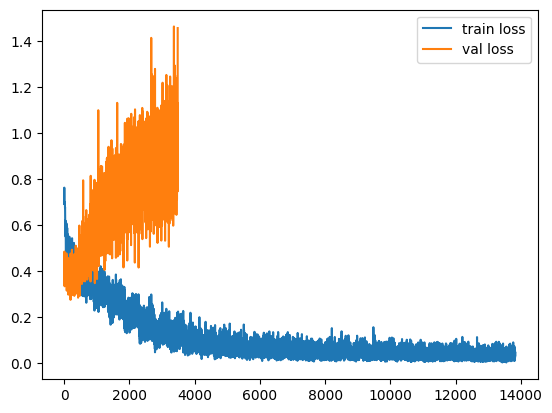

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

In [ ]:
max_len = 30
def pad_text(tokens):
    tokens = tokens[:max_len] + ['<pad>'] * (max_len - len(tokens))
    return tokens

In [ ]:
tkn_text = preprocessing("이 영화 개꿀잼 ㅋㅋㅋ")
padded_text = pad_text(tkn_text)
torch.tensor(TEXT_vocab(padded_text)).unsqueeze(0)

tensor([[   2, 2772,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]])

In [ ]:
import pandas as pd
text_df = pd.read_pickle('text_df.pkl')
text_df

,id,document,label,clean_review
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[더빙, 진짜, 짜증나다, 목소리]"
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,"[포스터, 보고, 초딩, 영화, 오버, 연기, 조차, 가볍다, 않다]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[무재, 밓었, 다그, 래서, 보다, 추천]"
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[교도소, 이야기, 구먼, 솔직하다, 재미, 없다, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[사이, 몬페, 익살스럽다, 연기, 돋보이다, 영화, 스파이더맨, 에서, 늙다, 보..."
...,...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0,"[인간, 문제, 죄인]"
149996,8549745,평점이 너무 낮아서...,1,"[평점, 너무, 낮다]"
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0,"[한국인, 거들다, 먹거리, 필리핀, 혼혈, 착하다]"
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1,"[청춘, 영화, 최고봉, 방황, 우울하다, 자화상]"


In [ ]:
import koreanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(model, sentence, label):
    model.eval()
    # tkn_text = preprocessing(sentence)
    input_tensor = torch.tensor(TEXT_vocab(sentence)).unsqueeze(0)

    with torch.no_grad():
        output, attn_weights = model(input_tensor.cuda())

    pred = 'Positive' if output.item() > 0 else 'Negative'

    attn_weights = attn_weights.squeeze().cpu().numpy()
    print(f'{pred}, {label} : {sentence}')
    # Attention 시각화
    plt.figure(figsize=(10, 3))
    plt.bar(range(len(attn_weights)), attn_weights)
    plt.xticks(range(len(sentence)), sentence, rotation=90)
    plt.xlabel('Words')
    plt.ylabel('Attention Weight')
    plt.title(f'Attention Visualization')
    plt.show()


Positive, 1 : ['정말', '재미있다', '보다', '크게', '웃다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


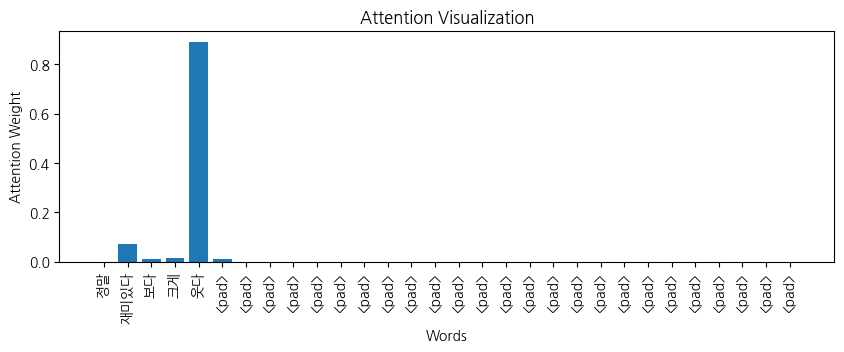

Positive, 1 : ['사상', '사상', '사상', '사람', '잡다', '사상', '최초', '왜곡', '하고', '독재', '물든', '경제체제', '정치사', '일시', '희망이', '되다', '종교', '라는', '아편', '상호', '배타', '적다', '하나', '쌍둥이', '처럼', '닮다', '인간', '보다', '정치', '종교']


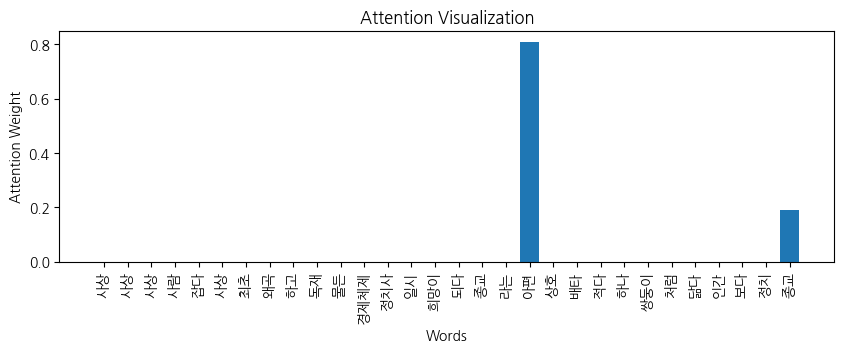

Negative, 0 : ['정녕', '년대', '화란', '말입', '니까', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


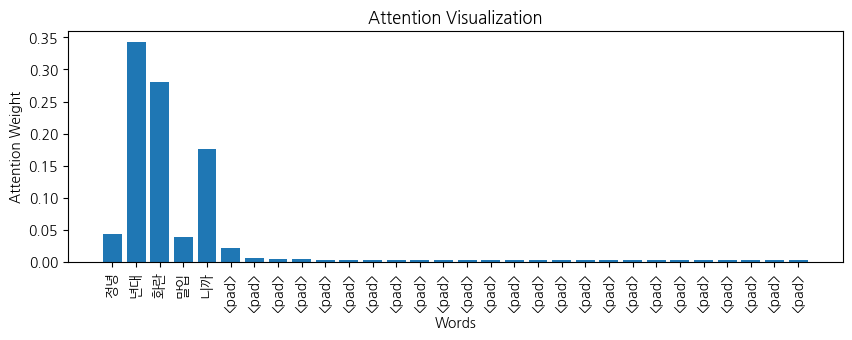

Positive, 1 : ['크다', '허다', '가슴', '아프다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


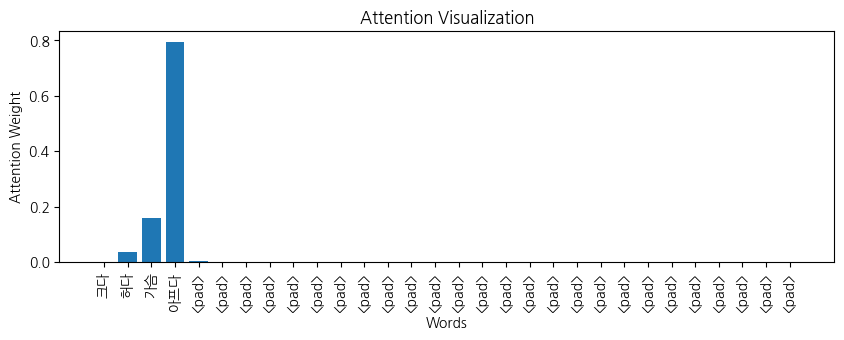

Positive, 1 : ['많다', '복선', '으로', '사회', '참담하다', '보여주다', '반면', '결국', '지키다', '자가', '보다', '되다', '사람', '잃다', '두렵다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


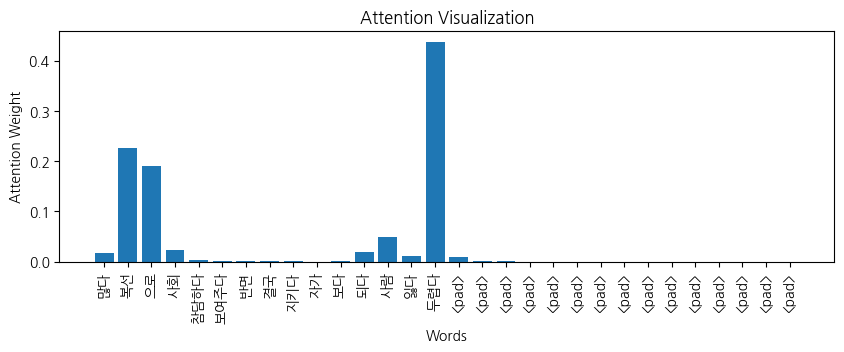

Negative, 0 : ['아이', '보다', '스토리', '진부하다', '감동', '별로', '예요', '지루하다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


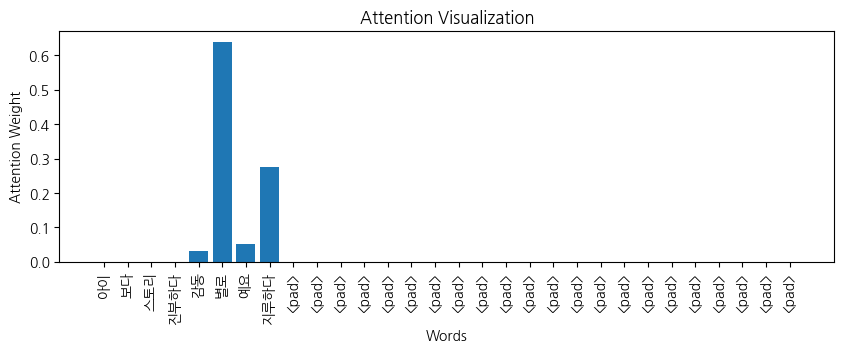

Positive, 1 : ['당신', '인생', '흔들다', '있다', '영화', '그리고', '음악', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


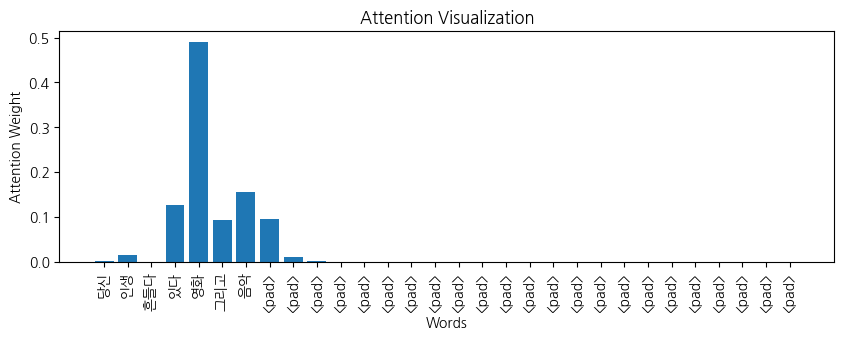

Positive, 1 : ['알다', '이유', '없다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


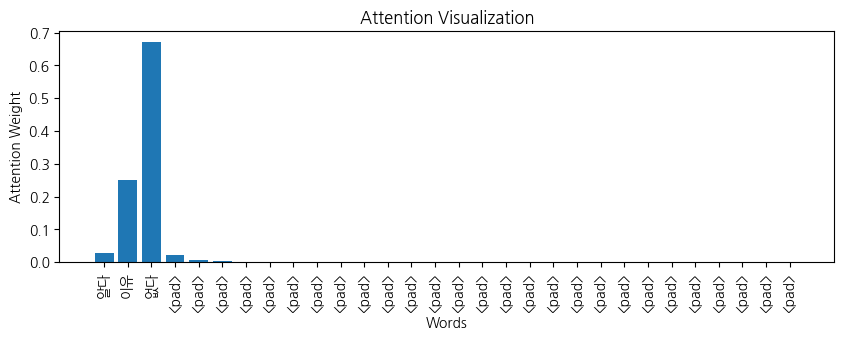

Positive, 1 : ['여기', '평론가', '엇갈리다', '좋다', '영화', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


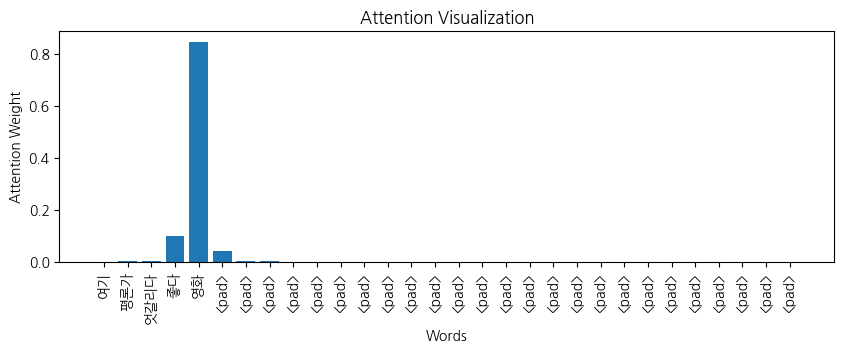

Positive, 1 : ['어리다', '비디오', '빌리다', '서다', '가족', '하고', '보다', '아버지', '한테', '내다', '맞다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


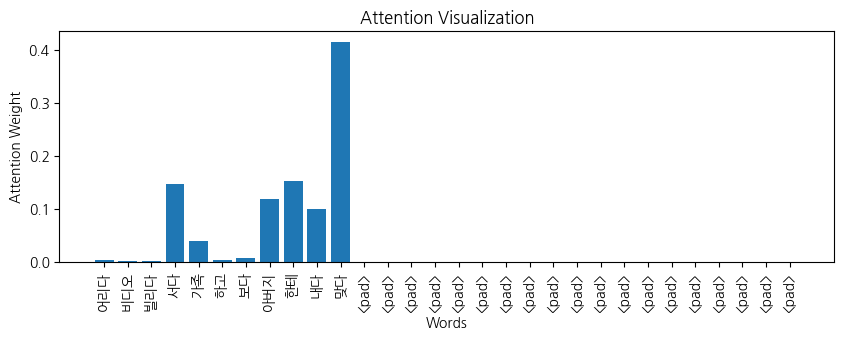

Positive, 1 : ['소재', '참신', '여주', '이뿌다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


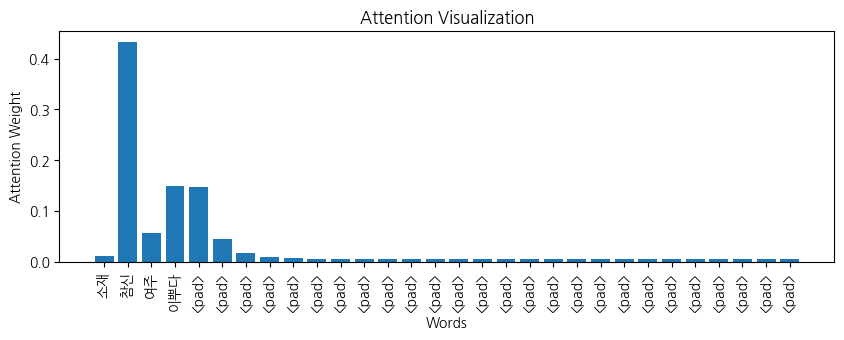

Negative, 0 : ['학교', '잡입', '이라는', '특이하다', '소재', '주성치', '특유', '코믹', '연기', '조합', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


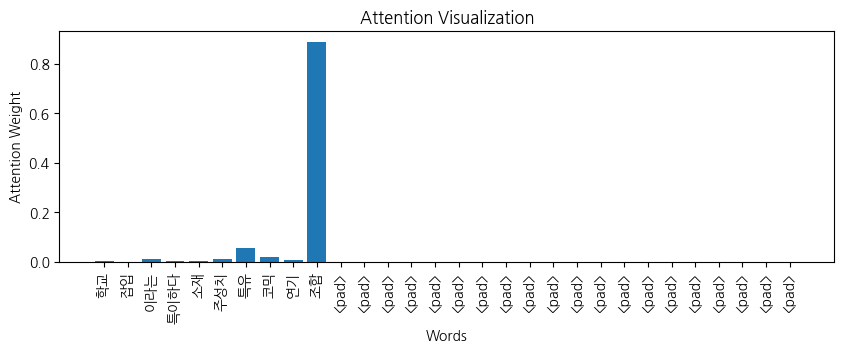

Negative, 0 : ['순위', '무크', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


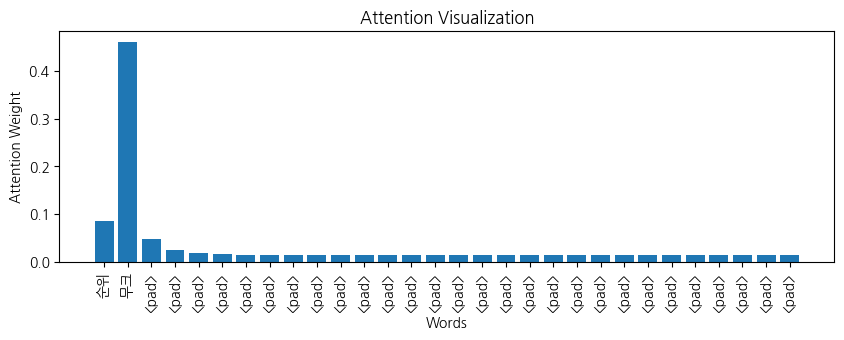

Negative, 0 : ['추천', '감동', '이삼', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


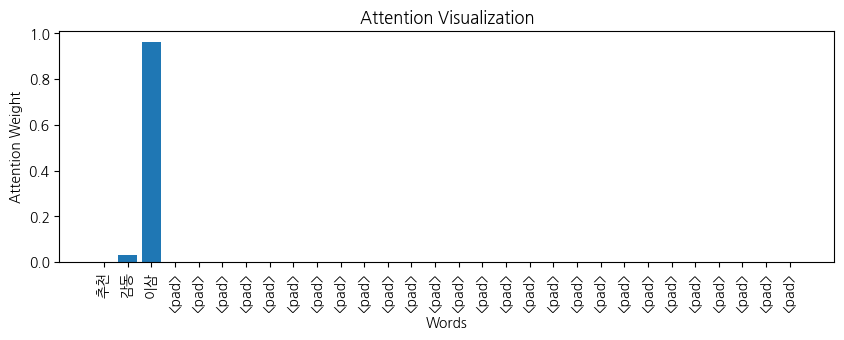

Negative, 0 : ['노무현', '코드', '맞다', '이준익', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


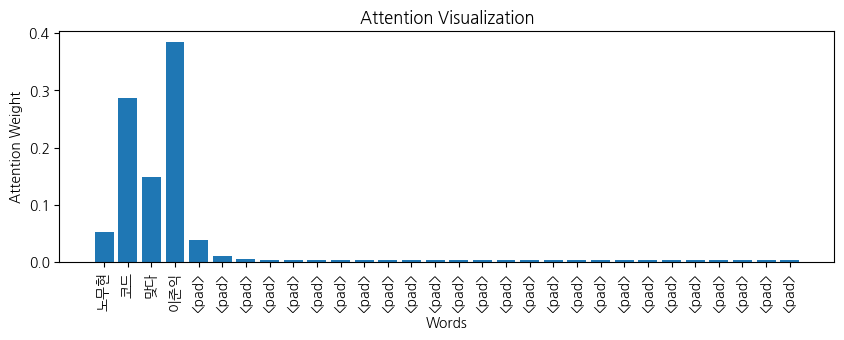

Positive, 1 : ['오랜', '생각나다', '보다', '역시', '최고', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


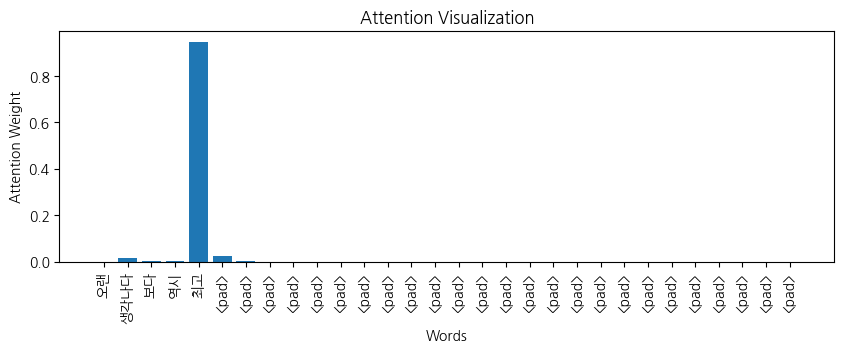

Negative, 0 : ['감독', '레옹', '찍다', '싶다', '보다', '송강호', '겨우', '까지', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


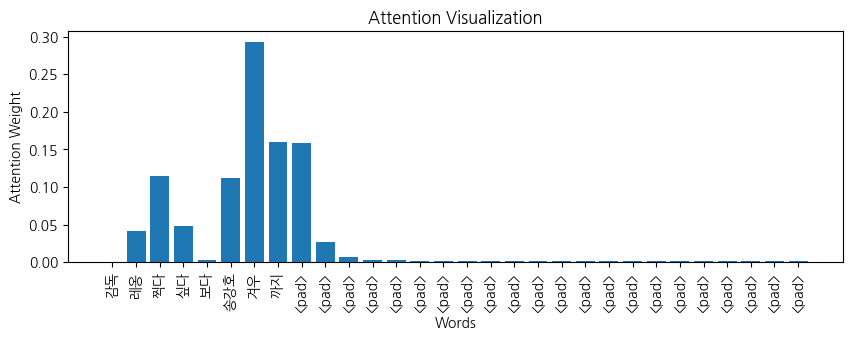

Positive, 1 : ['안타깝다', '웃음', '자아내다', '영화', '깊이', '느껴지다', '영화', '이다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


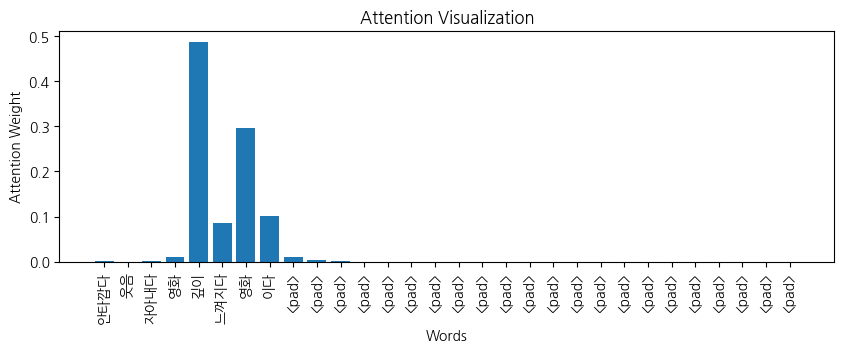

Negative, 0 : ['어지간하다', '영화', '좋아하다', '이건', '내용', '너무', '답답하다', '인물', '에게', '몰입', '하다', '여지', '한순간', '없다', '과거', '대한', '연출', '넣다', '모르다', '이렇다', '영화', '에서', '환각', '연출', '이라니', '대체', '무슨', '생각', '이다', '나오다']


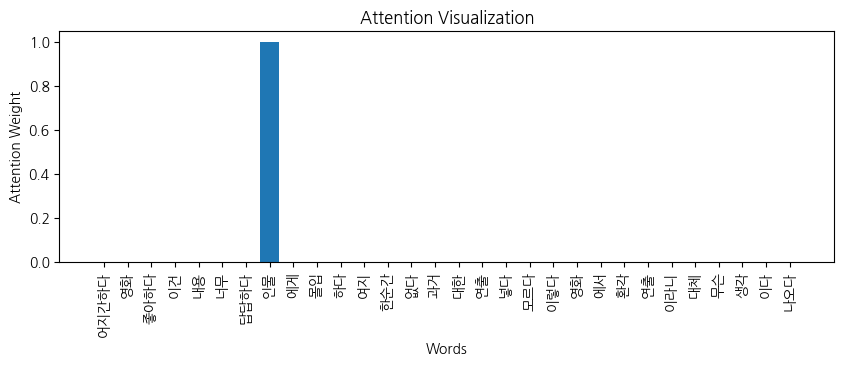

Negative, 0 : ['팽이', '쪼가리', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


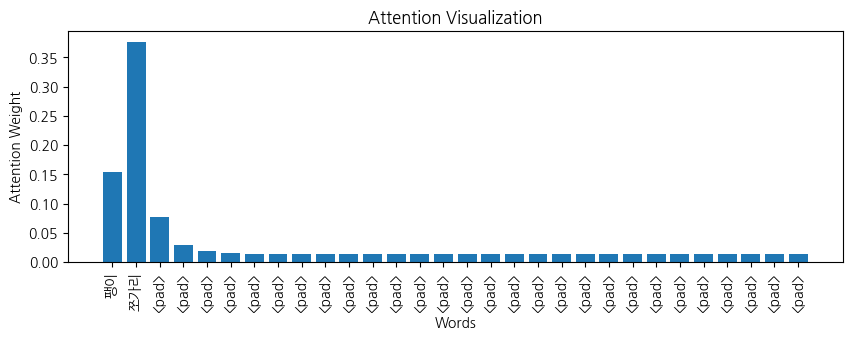

Positive, 1 : ['전율', '자체', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


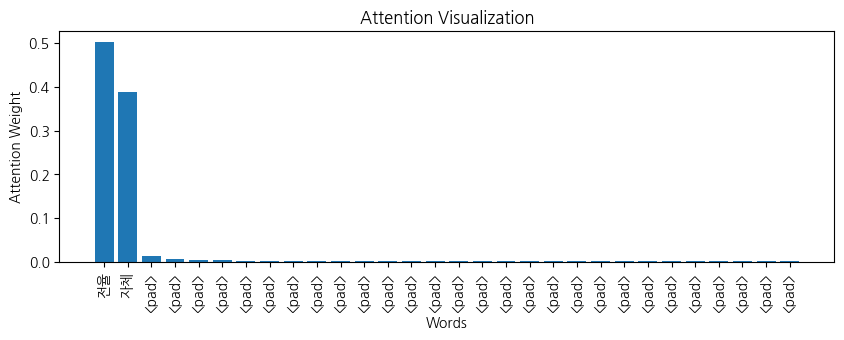

Negative, 0 : ['이런', '프로', '즐기다', '보다', '인데', '끼다', '보다', '정도', '공감', '안되다', '자르다', '여자', '패널', '너무', '세다', '남자', '넘다', '눌림', '중간', '에서', '지혜롭', '중재', '거나', '사람', '필요하다', '전현무', '때문', '끼다', '보다', '<pad>']


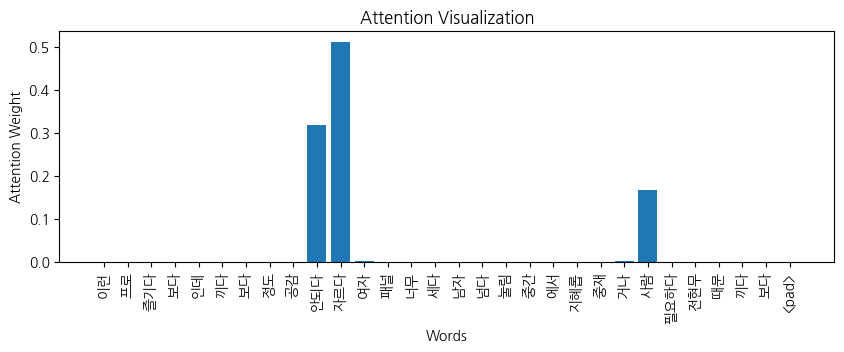

Positive, 1 : ['고딩', '경보', '극장', '에서', '보다', '정말', '재밌다', '보다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


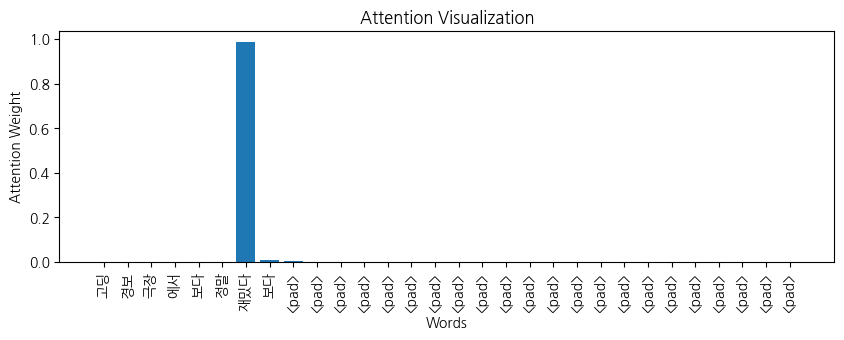

Negative, 0 : ['차라리', '포르노', '만들다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


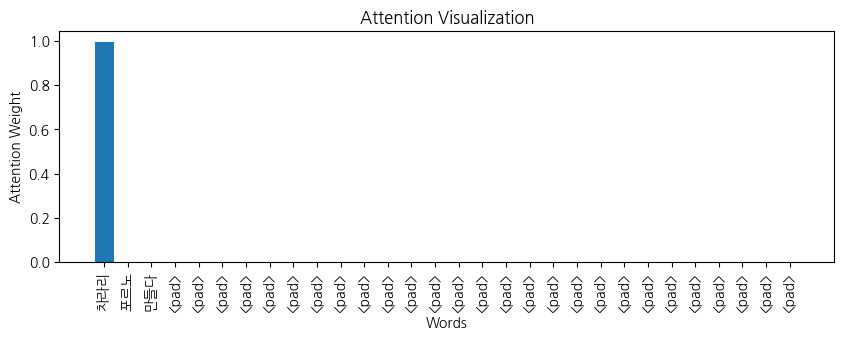

Positive, 1 : ['평점', '제대로', '주다', '초딩', '피타고라스', '정리', '버리다', '보다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


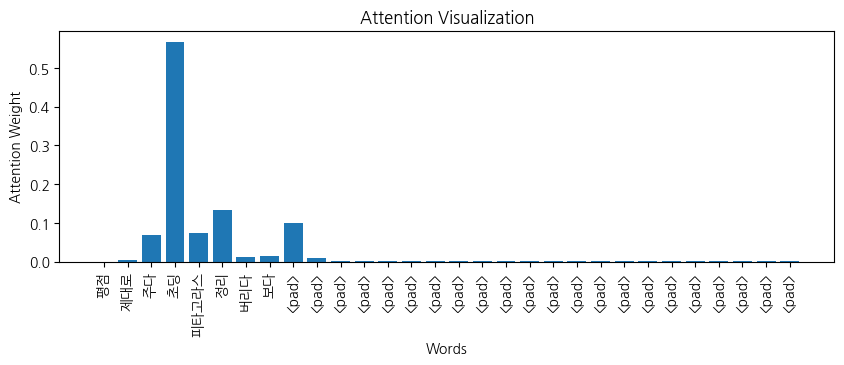

Positive, 1 : ['주인공', '모텔', '에서', '비디오', '틀다', '순간', '긴장감', '몰입', '되다', '지리다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


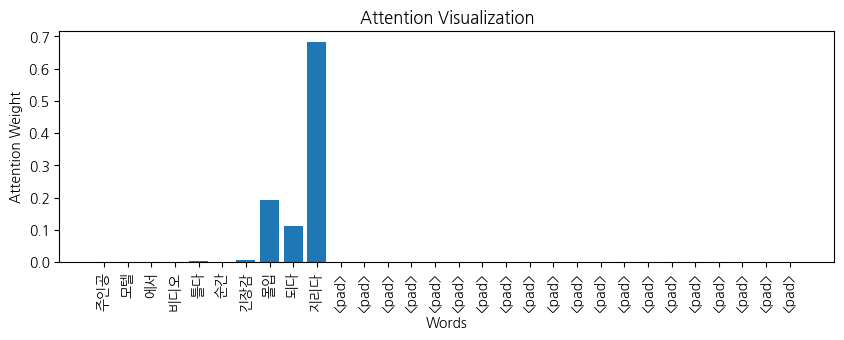

Positive, 1 : ['보고', '인형', '대안', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


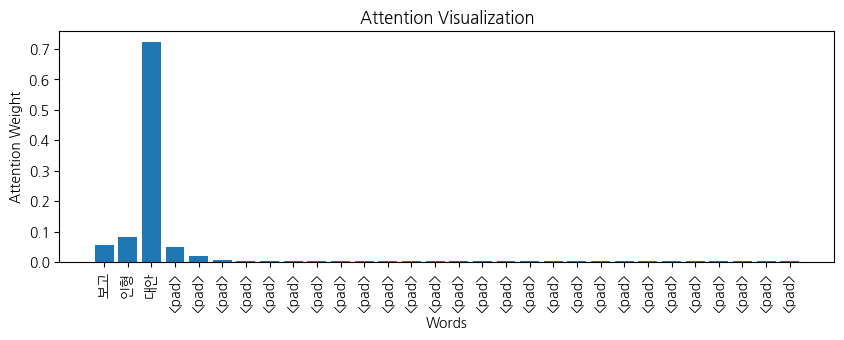

Negative, 0 : ['공포영화', '이다', '보구', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


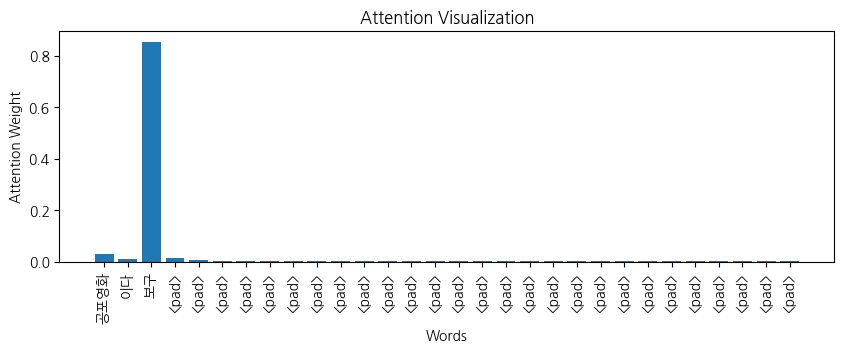

Negative, 0 : ['스텝업', '하다', '페임', '보다', '스토리', '라인', '쓰레기', '라고', '하다', '하다', '스텝업', '페임', '댄스', '장르', '최고', '명작', '들이다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


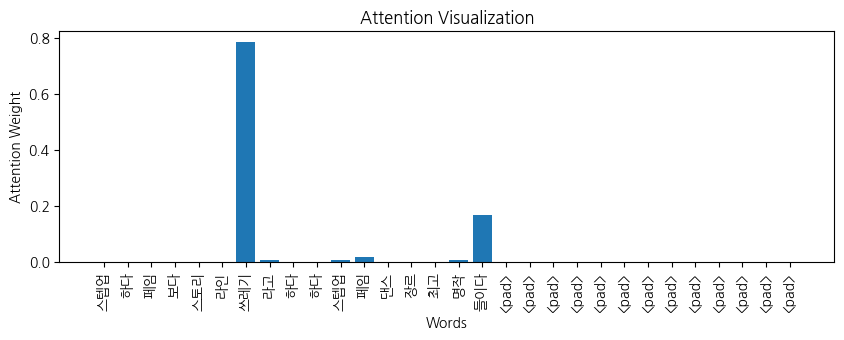

Positive, 1 : ['희다', '대의', '명작', '히틀러', '보고', '많다', '느끼다', '혹시', '이영화', '역사', '바꾸다', '아니다', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


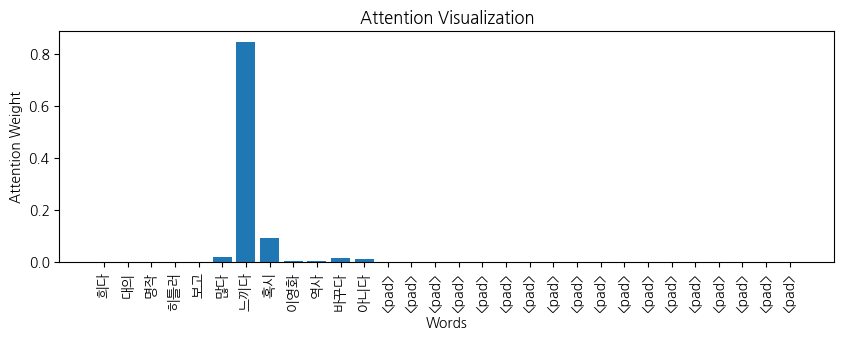

In [ ]:
import random
sample = random.choices(train_data, k = 30)
# sample = train_data.sample(30)
for sentence, label in sample:
    visualize_attention(model, sentence, label)

# 이미지 분류

In [ ]:
torch.__version__

'2.3.0+cu121'

In [ ]:
import torchvision
torchvision.__version__

'0.18.0+cu121'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

# FashionMNIST 데이터셋 로드 및 전처리
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:06<00:00, 4287760.63it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 109999.42it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:09<00:00, 469094.06it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7058606.40it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNWithAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, num_classes):
        super(CNNWithAttention, self).__init__()

        # CNN 레이어
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 임베딩을 위한 1x1 컨볼루션
        self.conv_embed = nn.Conv2d(64, embed_dim, kernel_size=1)

        # Attention을 위한 Linear 레이어
        self.fc_q = nn.Linear(embed_dim, embed_dim)
        self.fc_k = nn.Linear(embed_dim, embed_dim)
        self.fc_v = nn.Linear(embed_dim, embed_dim)
        self.attention = ScaledDotProductAttention(embed_dim)

        # 최종 분류 레이어
        self.fc_out = nn.Linear(embed_dim, num_classes)
        self.num_heads = num_heads
        self.embed_dim = embed_dim

    def forward(self, x):
        # CNN을 사용하여 특징 추출
        x = self.pool(F.relu(self.conv1(x)))  # (batch_size, 32, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))  # (batch_size, 64, 7, 7)

        # 1x1 컨볼루션으로 임베딩 차원으로 변환
        x = self.conv_embed(x)  # (batch_size, embed_dim, 7, 7)

        # 텐서를 (batch_size, seq_len, embed_dim)로 변환 (7x7을 시퀀스로 변환)
        x = x.view(x.size(0), self.embed_dim, -1).permute(0, 2, 1)  # (batch_size, 49, embed_dim)

        # Query, Key, Value 계산
        Q = self.fc_q(x)  # (batch_size, 49, embed_dim)
        K = self.fc_k(x)  # (batch_size, 49, embed_dim)
        V = self.fc_v(x)  # (batch_size, 49, embed_dim)

        # Scaled Dot-Product Attention 적용
        attn_output, attn_weights = self.attention(Q, K, V)

        # Attention 결과를 평균 내서 최종 분류에 사용
        out = attn_output.mean(dim=1)  # (batch_size, embed_dim)
        out = self.fc_out(out)  # (batch_size, num_classes)

        return out, attn_weights


In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.cuda(), labels.cuda()

            # 모델 예측 및 손실 계산
            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')


In [ ]:
# 하이퍼파라미터 설정
embed_dim = 128  # Attention 메커니즘을 위한 임베딩 차원
num_heads = 4  # Attention Head 수
num_classes = 10  # FashionMNIST 클래스 수"

# 모델, 손실 함수, 옵티마이저 정의
model = CNNWithAttention(embed_dim, num_heads, num_classes).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
train_model(model, train_loader, criterion, optimizer, num_epochs=5)

Epoch [1/5], Loss: 0.9826
Epoch [2/5], Loss: 0.6274
Epoch [3/5], Loss: 0.5236
Epoch [4/5], Loss: 0.4745
Epoch [5/5], Loss: 0.4422


In [ ]:
images, labels = next(iter(test_loader))
outputs, attn_weights = model(images.cuda())
print(labels)
print(outputs.argmax(dim=1))

print(attn_weights[0].shape)
# plt.imshow(images[0].squeeze(), cmap='gray')
# plt.show()
# plt.imshow(attn_weights[0].squeeze().cpu().detach().numpy().reshape(28, 28), cmap='hot', interpolation='nearest')
# plt.show()

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5])
tensor([9, 2, 1, 1, 6, 1, 2, 2, 5, 7, 4, 5, 5, 3, 4, 1, 2, 2, 8, 0, 2, 5, 7, 5,
        1, 2, 4, 0, 9, 6, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 6, 9, 6, 5, 2, 1,
        4, 2, 6, 2, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5], device='cuda:0')
torch.Size([49, 49])


In [ ]:
model.fc_out.weight.data.shape

torch.Size([10, 128])

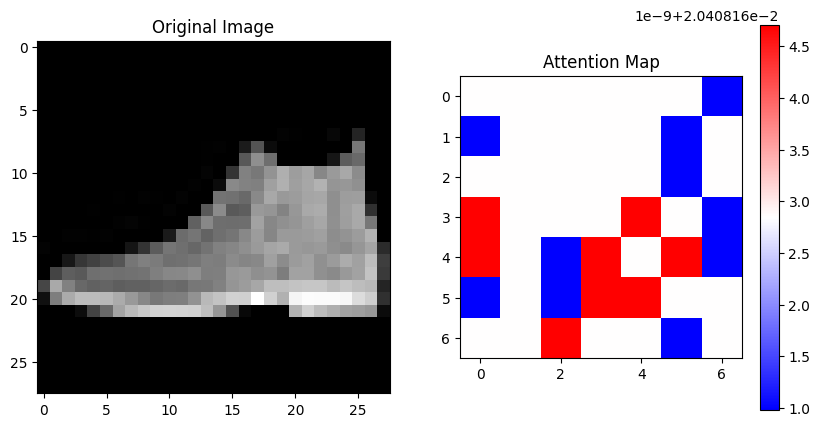

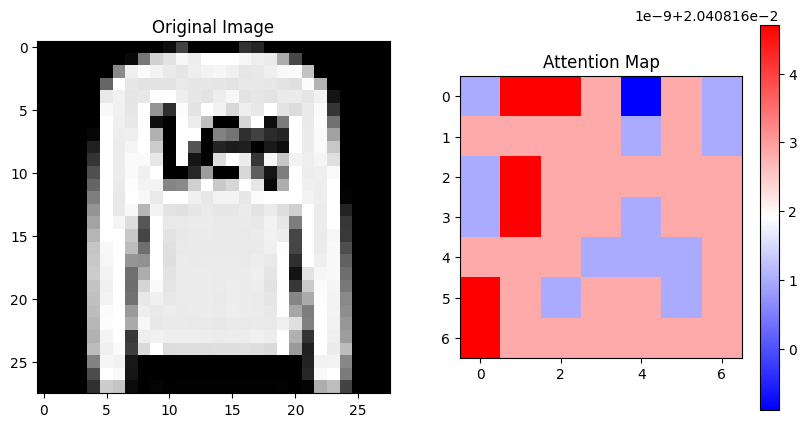

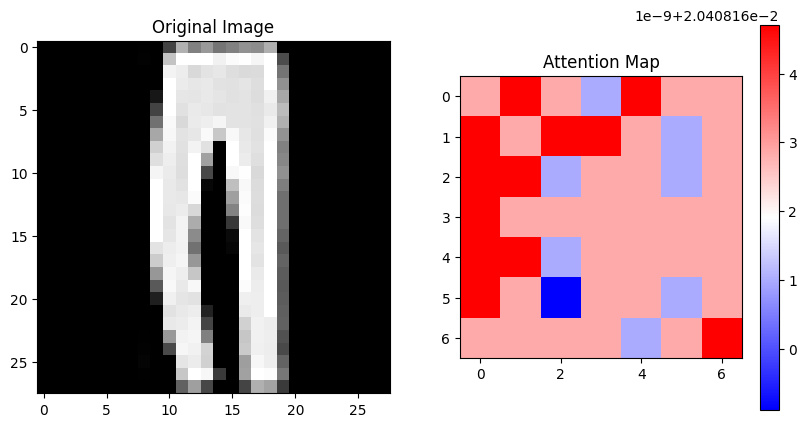

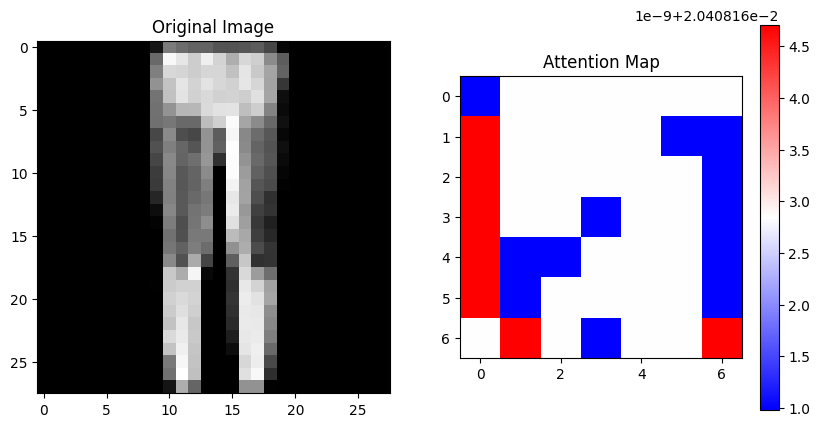

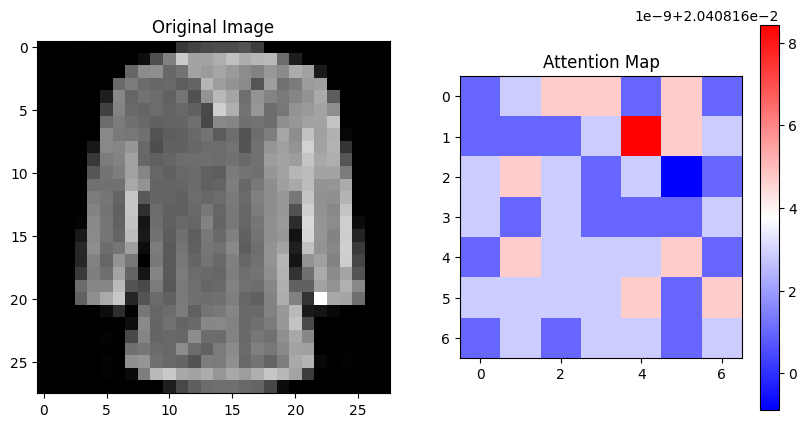

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(image, attn_weights):
    # 이미지 복원
    image = image.squeeze().cpu().numpy()

    attn_weights = attn_weights.mean(dim=1).cpu().detach().numpy()  # 각 헤드의 평균
    attn_weights = attn_weights.reshape(7, 7)  # (batch_size, channel, 7, 7)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')

    ax[1].imshow(attn_weights, cmap='bwr')
    ax[1].set_title('Attention Map')
    fig.colorbar(ax[1].imshow(attn_weights, cmap='bwr'))
    plt.show()

# 테스트 데이터에서 하나의 샘플을 시각화
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs, attn_weights = model(images)

        # Attention 가중치를 시각화
        for i in range(5):

            visualize_attention(images[i], attn_weights[i])
        break
